# Load data and fragment + index

In [ ]:
import os
import pandas as pd
from rdkit import Chem
import subprocess
import hashlib
import tempfile
from tqdm import tqdm
import base64
class MMPGenerator:
    def __init__(self, df_input, output_csv, mmpa_dir='./mmpa',
                 symmetric=True, max_heavy=14, max_ratio=0.7, verbose=True):
        self.df_original = df_input.copy()
        self.output_csv = output_csv
        self.mmpa_dir = mmpa_dir
        self.symmetric = symmetric
        self.max_heavy = max_heavy
        self.max_ratio = max_ratio
        self.verbose = verbose

    def _get_inchikey(self, smiles):
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Chem.inchi.MolToInchiKey(mol)
        return self.encode_string(smiles)

    def encode_string(self, s):
        return base64.urlsafe_b64encode(s.encode()).decode()

    def decode_string(self, b64):
        return base64.urlsafe_b64decode(b64.encode()).decode()

    def run(self):
        self.df_original['ID'] = [self._get_inchikey(smi) for smi in self.df_original['SMILES']]
        y_map = self.df_original.set_index('ID')['Y'].to_dict()

        with tempfile.TemporaryDirectory() as tmp:
            smi_path = os.path.join(tmp, 'input.smi')
            frag_path = os.path.join(tmp, 'fragmented.txt')
            mmps_path = os.path.join(tmp, 'mmps.csv')
            smirks_path = os.path.join(tmp, 'smirks.txt')
            cansmirks_path = os.path.join(tmp, 'cansmirks.txt')

            self.df_original[['SMILES', 'ID']].to_csv(smi_path, index=False, sep=' ', header=False)

            with open(frag_path, 'w') as out:
                subprocess.run(['python', f'{self.mmpa_dir}/rfrag.py'], stdin=open(smi_path), stdout=out)

            cmd = ['python', f'{self.mmpa_dir}/indexing.py']
            if self.symmetric:
                cmd.append('-s')
            if self.max_heavy:
                cmd.extend(['-m', str(self.max_heavy)])
            if self.max_ratio:
                cmd.extend(['-r', str(self.max_ratio)])

            with open(mmps_path, 'w') as out:
                subprocess.run(cmd, stdin=open(frag_path), stdout=out)

            with open(mmps_path) as f:
                lines = [line.strip() for line in f if line.strip()]


            splits = [line.split(',') for line in lines]
            max_len = max(len(s) for s in splits)

            df = pd.DataFrame(splits, columns=['L_SMILES', 'R_SMILES', 'L_ID', 'R_ID', 'SMIRKS', 'CORE'])


            df['L_Y'] = df['L_ID'].map(y_map)
            df['R_Y'] = df['R_ID'].map(y_map)
            df['Delta_Y'] = df['R_Y'] - df['L_Y']

            df = df[df['SMIRKS'].apply(lambda x: isinstance(x, str) and '>>' in x)]

            df['__row'] = range(len(df))
            df[['SMIRKS', '__row']].to_csv(smirks_path, index=False, sep=' ', header=False)

            with open(cansmirks_path, 'w') as out:
                subprocess.run(['python', f'{self.mmpa_dir}/cansmirk.py'], stdin=open(smirks_path), stdout=out)


            canon_df = pd.read_csv(cansmirks_path, sep=' ', names=['Canonical_SMIRKS', 'index'])


            df = df.merge(canon_df, left_on='__row', right_on='index').drop(columns=['__row', 'index'])

            df[['L_sub', 'R_sub']] = df['Canonical_SMIRKS'].str.split('>>', expand=True)


            df['L_sub_ID'] = [self.encode_string(k) for k in df['L_sub'].tolist()]
            df['R_sub_ID'] = [self.encode_string(k) for k in df['R_sub'].tolist()]
            df['SMIRKS_ID'] = [self.encode_string(k) for k in df['Canonical_SMIRKS'].tolist()]
            df['CORE_ID'] = [self.encode_string(k) for k in df['CORE'].tolist()]
            df = df.drop_duplicates()


            df[['L_SMILES', 'R_SMILES', 'L_ID', 'R_ID', 'SMIRKS', 'CORE', 'L_Y', 'R_Y', 'Delta_Y', 'L_sub', 'R_sub', 'L_sub_ID', 'R_sub_ID', 'SMIRKS_ID', 'CORE_ID']].to_csv(
                self.output_csv, index=False
            )




import pandas as pd
import numpy as np
from itertools import combinations
from scipy.stats import pearsonr
from tqdm import tqdm
import time

class MMPAugmentorFixed:
    def __init__(self, df, min_common=4, pearson_thresh=0.3, crmsd_thresh=0.4):
        self.df = df.copy()
        self.min_common = min_common
        self.pearson_thresh = pearson_thresh
        self.crmsd_thresh = crmsd_thresh
        self.series = {}
        self.pair_scores = []
        self.filtered_pairs = []
        self.augmented_data = []

    def _extract_series(self):
        start = time.time()
        self.series = {
            core: group for core, group in self.df.groupby("CORE")
        }

    def _compute_pairwise_scores(self):
        start = time.time()
        self.pair_scores = []
        series_items = list(self.series.items())
        total_combinations = len(series_items) * (len(series_items) - 1) // 2
        for (core1, df1), (core2, df2) in   combinations(series_items, 2):
            subs1 = set(df1["L_sub"])
            subs2 = set(df2["L_sub"])
            common = subs1 & subs2
            if len(common) < self.min_common:
                continue

            merged = pd.merge(
                df1, df2,
                left_on=["L_sub", "R_sub"],
                right_on=["L_sub", "R_sub"],
                suffixes=('_1', '_2')
            )
            if len(merged) < self.min_common:
                continue

            y1 = merged['Delta_Y_1'].values
            y2 = merged['Delta_Y_2'].values
            crmsd = np.sqrt(np.mean((y1 - y2) ** 2))
            try:
                corr = pearsonr(y1, y2)[0]
            except:
                corr = np.nan

            self.pair_scores.append((core1, core2, crmsd, corr, len(merged)))

    def _filter_pairs(self):
        start = time.time()
        self.filtered_pairs = [
            (s1, s2) for s1, s2, rmsd, corr, n in self.pair_scores
            if rmsd <= self.crmsd_thresh and (not np.isnan(corr) and corr >= self.pearson_thresh)
        ]

    def _augment(self):
        start = time.time()
        augmented_entries = []
        for s1, s2 in self.filtered_pairs:
            df1 = self.series[s1]
            df2 = self.series[s2]

            tf1 = df1.groupby("L_sub")[["R_sub", "Delta_Y"]].first().to_dict("index")
            tf2 = df2.groupby("L_sub")[["R_sub", "Delta_Y"]].first().to_dict("index")

            df1_dict = df1.groupby("L_sub").first().to_dict("index")
            df2_dict = df2.groupby("L_sub").first().to_dict("index")

            for l_sub, entry in tf1.items():
                base = df2_dict.get(l_sub)
                if base:
                    r_sub = entry["R_sub"]
                    delta = entry["Delta_Y"]
                    new_y = base["L_Y"] + delta
                    smirks_new = l_sub + ">>" + r_sub
                    augmented_entries.append({
                        "CORE": s1,
                        "L_sub": l_sub,

                        "R_sub": r_sub,
                        "L_Y": base["L_Y"],
                        "R_Y": new_y,
                        "Delta_Y": delta,
                        "Annotation": "Predicted",
                        "L_SMILES": base.get("L_SMILES"),
                        "L_ID": base.get("L_ID"),
                        "L_sub_ID": base.get("L_sub_ID"),
                        "R_sub_ID": base64.urlsafe_b64encode(r_sub.encode()).decode(),
                        "SMIRKS": smirks_new, # not correct should be from df1 and not df2
                        "SMIRKS_ID": base64.urlsafe_b64encode(smirks_new.encode()).decode(),
                        "CORE_ID": base64.urlsafe_b64encode(s1.encode()).decode()
                    })

            for l_sub, entry in tf2.items():
                base = df1_dict.get(l_sub)
                if base:
                    r_sub = entry["R_sub"]
                    delta = entry["Delta_Y"]
                    new_y = base["L_Y"] + delta
                    # augmented_entries.append({
                    #     "CORE": s2, # changed to s2 from s1
                    #     "L_sub": l_sub,
                    #     "R_sub": r_sub,
                    #     "L_Y": base["L_Y"],
                    #     "R_Y": new_y,
                    #     "Delta_Y": delta,
                    #     "Annotation": "Predicted",
                    #     "L_SMILES": base.get("L_SMILES"),
                    #     "L_ID": base.get("L_ID"),
                    #     "L_sub_ID": base.get("L_sub_ID"),
                    #     "R_sub_ID": base.get("R_sub_ID"),
                    #     "SMIRKS": base.get("SMIRKS"),
                    #     "SMIRKS_ID": base.get("SMIRKS_ID"),
                    #     "CORE_ID": base.get("CORE_ID") 
                    # })
                    smirks_new = l_sub + ">>" + r_sub
                    augmented_entries.append({
                        "CORE": s2, # changed to s2 from s1
                        "L_sub": l_sub,
                        "R_sub": r_sub,
                        "L_Y": base["L_Y"],
                        "R_Y": new_y,
                        "Delta_Y": delta,
                        "Annotation": "Predicted",
                        "L_SMILES": base.get("L_SMILES"),
                        "L_ID": base.get("L_ID"),
                        "L_sub_ID": base.get("L_sub_ID"),
                        "R_sub_ID": base64.urlsafe_b64encode(r_sub.encode()).decode(),
                        "SMIRKS": smirks_new, # not correct should be from df1 and not df2
                        "SMIRKS_ID": base64.urlsafe_b64encode(smirks_new.encode()).decode(),
                        "CORE_ID": base64.urlsafe_b64encode(s2.encode()).decode()
                    })




        self.augmented_data = pd.DataFrame(augmented_entries)

    def run(self):
        self._extract_series()
        self._compute_pairwise_scores()
        self._filter_pairs()
        self._augment()

        original = self.df.copy()
        original["Annotation"] = "Experimental"
        return pd.concat([original, self.augmented_data], ignore_index=True)
    
    def get_pair_scores_df(self):
        """
        Return a DataFrame of scaffold pair scores (cRMSD, Pearson, common MMP count)
        """
        return pd.DataFrame(
            self.pair_scores,
            columns=["Scaffold_1", "Scaffold_2", "cRMSD", "Pearson", "N_common"]
        )

    def get_augmented_only(self):
        """
        Return only the augmented (predicted) entries.
        """
        return self.augmented_data.copy()
    

def analyze_scaffold_pair_scores(df):
    import seaborn as sns
    import matplotlib.pyplot as plt

    summary = {
        "Total Pairs": len(df),
        "Mean cRMSD": df["cRMSD"].mean(),
        "Median cRMSD": df["cRMSD"].median(),
        "Std cRMSD": df["cRMSD"].std(),
        "Mean Pearson": df["Pearson"].mean(),
        "Median Pearson": df["Pearson"].median(),
        "Std Pearson": df["Pearson"].std(),
        "Mean N_common": df["N_common"].mean(),
        "Median N_common": df["N_common"].median()
    }

    high_corr = df["Pearson"] > 0.7
    low_crmsd = df["cRMSD"] < 0.5
    enough_common = df["N_common"] >= 5
    strong_pairs = df[high_corr & low_crmsd & enough_common]

    summary.update({
        "High Pearson (>0.7)": high_corr.sum(),
        "Low cRMSD (<0.5)": low_crmsd.sum(),
        "N_common ≥ 5": enough_common.sum(),
        "Strong Pairs (all 3)": len(strong_pairs)
    })

 



    top_corr = df.sort_values("Pearson", ascending=False).head(5)
    top_low_crmsd = df.sort_values("cRMSD").head(5)
    top_common = df.sort_values("N_common", ascending=False).head(5)

    return {
        "summary": summary,
        "top_corr": top_corr,
        "top_low_crmsd": top_low_crmsd,
        "top_common": top_common,
        "strong_pairs": strong_pairs
    }


def prepare_and_plot_prediction_vs_experiment_complete_with_output(clean_df, std_threshold=0.5):
    import seaborn as sns
    import matplotlib.pyplot as plt

    clean_df_exp = clean_df[clean_df["Annotation"] != "Predicted"].copy()
    clean_df_pred = clean_df[clean_df["Annotation"] == "Predicted"].copy()

    # Normalize column names
    clean_df_exp = clean_df_exp.rename(columns={"R_SMILES": "SMILES", "R_Y": "Y"})
    clean_df_pred = clean_df_pred.rename(columns={"R_SMILES": "SMILES", "R_Y": "Y"})

    # Compute median and std per SMILES in predicted
    grouped_pred = clean_df_pred.groupby("SMILES")["Y"].agg(["median", "std"]).reset_index()
    grouped_pred.columns = ["SMILES", "Y", "Predicted_Std_Y"]
    grouped_pred["Annotation"] = "Predicted"

    grouped_pred = grouped_pred[grouped_pred["Predicted_Std_Y"]<= std_threshold]

    # Final prediction rows
    exp_out = clean_df_exp[["SMILES", "Y"]].copy()
    exp_out["Predicted_Std_Y"] = None
    exp_out["Annotation"] = "Experimental"

    output_df = pd.concat([exp_out.drop_duplicates("SMILES") , grouped_pred.drop_duplicates("SMILES") ], ignore_index=True)
    output_df = output_df[~((output_df['Annotation'] == 'Predicted') & (output_df['SMILES'].isin(output_df.loc[output_df['Annotation'] == 'Experimental', 'SMILES'])))]

    # Merge only for shared SMILES
    merged_df = pd.merge(clean_df_exp, grouped_pred, on="SMILES", how="inner")

    # === BARPLOT OF COUNTS ===
    exp_unique = set(clean_df_exp["SMILES"])
    pred_unique = set(clean_df_pred["SMILES"])
    shared = exp_unique & pred_unique
    only_pred = pred_unique - exp_unique

    counts = {
        "Experimental Only": len(exp_unique - pred_unique),
        "Predicted Only": len(only_pred),
        "Shared": len(shared),
        "Experimental Total": len(exp_unique),
        "Predicted Total": len(pred_unique)
    }

    return merged_df, output_df


import time
from sklearn.metrics import mean_squared_error, r2_score
def full_rf_validation_pipeline_profiled():
    from rdkit import Chem
    from rdkit.Chem import DataStructs
    from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import KFold
    import numpy as np
    import pandas as pd
    from tqdm import tqdm
    from joblib import Parallel, delayed

    def compute_single_fp(smi, radius=4, n_bits=4096):
        from rdkit import Chem
        from rdkit.Chem import DataStructs
        from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            generator = GetMorganGenerator(radius=radius, fpSize=n_bits)
            fp = generator.GetFingerprint(mol)
            arr = np.zeros((1,), dtype=int)
            DataStructs.ConvertToNumpyArray(fp, arr)
            return arr
        return np.full(n_bits, 0)

    def compute_all_fingerprints_parallel(data, radius=4, n_bits=4096, n_jobs=-1):
        t0 = time.time()
        fps = Parallel(n_jobs=n_jobs)(
            delayed(compute_single_fp)(smi) for smi in data["SMILES"]
        )
        return np.array(fps)



    def evaluate_rf_on_augmentation(data, n_splits=5, n_repeats=5):
        data = data.dropna(subset=["SMILES", "Y"]).reset_index(drop=True)
        all_fps = compute_all_fingerprints_parallel(data)
        results = []
        metrics = []

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        fold = 0
        exp_indices = data[data.Annotation == "Experimental"].index.to_numpy()

        for train_idx, test_idx in kf.split(exp_indices):
            fold += 1
            train_exp_idx = exp_indices[train_idx]
            test_exp_idx = exp_indices[test_idx]
            pred_idx = data[data.Annotation == "Predicted"].index.to_numpy()
            train_aug_idx = np.concatenate([train_exp_idx, pred_idx])

            X_train_exp = all_fps[train_exp_idx]
            y_train_exp = data.loc[train_exp_idx, "Y"].values
            X_train_aug = all_fps[train_aug_idx]
            y_train_aug = data.loc[train_aug_idx, "Y"].values
            X_test = all_fps[test_exp_idx]
            y_test = data.loc[test_exp_idx, "Y"].values
            smiles_test = data.loc[test_exp_idx, "SMILES"].values


            preds_aug, preds_noaug = [], []

            for rep in range(n_repeats):
                t1 = time.time()
                model_aug = RandomForestRegressor(n_jobs=-1, random_state=np.random.randint(10000), n_estimators=300)
                model_aug.fit(X_train_aug, y_train_aug)

                t2 = time.time()
                model_noaug = RandomForestRegressor(n_jobs=-1, random_state=np.random.randint(10000), n_estimators=300)
                model_noaug.fit(X_train_exp, y_train_exp)

                preds_aug.append(model_aug.predict(X_test))
                preds_noaug.append(model_noaug.predict(X_test))

            y_pred_aug = np.median(np.array(preds_aug), axis=0)
            y_pred_noaug = np.median(np.array(preds_noaug), axis=0)

            rmse_aug = mean_squared_error(y_test, y_pred_aug, squared=False)
            r2_aug = r2_score(y_test, y_pred_aug)
            rmse_noaug = mean_squared_error(y_test, y_pred_noaug, squared=False)
            r2_noaug = r2_score(y_test, y_pred_noaug)

            metrics.append({
                "Fold": fold,
                "RMSE_Aug": rmse_aug,
                "R2_Aug": r2_aug,
                "RMSE_NoAug": rmse_noaug,
                "R2_NoAug": r2_noaug
            })

            for i, smi in enumerate(smiles_test):
                true_y = y_test[i]
                aug_preds = [p[i] for p in preds_aug]
                noaug_preds = [p[i] for p in preds_noaug]

                results.append({
                    "SMILES": smi,
                    "True_Y": true_y,
                    "Median_Pred_Aug": np.median(aug_preds),
                    "Std_Pred_Aug": np.std(aug_preds),
                    "Med_AE_Aug": np.median(np.abs(np.array(aug_preds) - true_y)),
                    "Median_Pred_NoAug": np.median(noaug_preds),
                    "Std_Pred_NoAug": np.std(noaug_preds),
                    "Med_AE_NoAug": np.median(np.abs(np.array(noaug_preds) - true_y)),
                    "Fold": fold
                })

        metrics_df = pd.DataFrame(metrics)

        return pd.DataFrame(results), metrics_df
    return evaluate_rf_on_augmentation


def fast_apply_transformation(transformation, smiles, rxn_cache):
    if pd.isna(transformation) or pd.isna(smiles):
        return None
    if transformation not in rxn_cache:
        rxn = AllChem.ReactionFromSmarts(transformation)
        rxn_cache[transformation] = rxn
    else:
        rxn = rxn_cache[transformation]
    if rxn is None:
        return None
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    try:
        products = rxn.RunReactants((mol,))
    except Exception:
        return None
    if products and products[0]:
        return Chem.MolToSmiles(products[0][0])
    return None

def update_predicted_rows(df):
    mask = df["Annotation"] == "Predicted"
    indices = df[mask].index

    rxn_cache = {}
    for idx in indices:
        row = df.loc[idx]
        l_smiles = row["L_SMILES"]
        smirks = row["SMIRKS"]
        r_smiles = fast_apply_transformation(smirks, l_smiles, rxn_cache)
        if r_smiles:
            mol = Chem.MolFromSmiles(r_smiles)
            r_id = Chem.InchiToInchiKey(Chem.MolToInchi(mol)) if mol else None
        else:
            r_id = None
        df.at[idx, "R_SMILES"] = r_smiles
        df.at[idx, "R_ID"] = r_id

    return df

import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

def plot_cv_metrics(metrics_df):
    plt.figure(figsize=(12, 5))

    # Boxplot RMSE
    plt.subplot(1, 2, 1)
    rmse_melted = metrics_df.melt(id_vars="Fold", value_vars=["RMSE_Aug", "RMSE_NoAug"],
                                  var_name="Condition", value_name="RMSE")
    sns.boxplot(data=rmse_melted, x="Condition", y="RMSE", palette="Set2")
    plt.title("RMSE per Fold")
    plt.grid(True)

    # Boxplot R2
    plt.subplot(1, 2, 2)
    r2_melted = metrics_df.melt(id_vars="Fold", value_vars=["R2_Aug", "R2_NoAug"],
                                var_name="Condition", value_name="R²")
    sns.boxplot(data=r2_melted, x="Condition", y="R²", palette="Set2")
    plt.title("R² per Fold")
    plt.grid(True)

    plt.tight_layout()
    plt.show()


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_top_models_summary(results_list, top_n=10):
    df_pareto = pd.DataFrame(results_list)
    df_top = df_pareto.sort_values(by=['median_r2', 'median_size_increase'], ascending=[False, False]).head(top_n)

    print("=== Top Pareto Models ===")
    print(df_top[['trial', 'median_r2', 'median_size_increase', 'params']])

    # Collect and combine all metric DataFrames
    metric_records = []
    for _, row in df_top.iterrows():
        for detail in row['details']:
            df = detail['metrics_df'].copy()
            df['Target'] = detail['col']
            df['Trial'] = row['trial']
            metric_records.append(df)

    combined_df = pd.concat(metric_records, ignore_index=True)

    # Aggregate per target
    agg_df = combined_df.groupby('Target').agg({
        'R2_Aug': ['mean', 'std'],
        'R2_NoAug': ['mean', 'std'],
        'RMSE_Aug': ['mean'],
        'RMSE_NoAug': ['mean']
    })
    agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]
    agg_df = agg_df.reset_index()

    # Calculate improvement
    agg_df['Delta_R2'] = agg_df['R2_Aug_mean'] - agg_df['R2_NoAug_mean']
    agg_df['Delta_RMSE'] = agg_df['RMSE_NoAug_mean'] - agg_df['RMSE_Aug_mean']

    print("\n=== Per-Target Summary ===")
    print(agg_df[['Target', 'R2_NoAug_mean', 'R2_Aug_mean', 'Delta_R2', 'RMSE_NoAug_mean', 'RMSE_Aug_mean', 'Delta_RMSE']])

    # Plot: R2 Augmented vs Non-Augmented per target
    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    index = range(len(agg_df))
    plt.bar(index, agg_df['R2_NoAug_mean'], bar_width, label='Non-Augmented')
    plt.bar([i + bar_width for i in index], agg_df['R2_Aug_mean'], bar_width, label='Augmented')
    plt.xticks([i + bar_width / 2 for i in index], agg_df['Target'], rotation=45, ha='right')
    plt.ylabel("Mean R2")
    plt.title("Mean R2 per Target (Augmented vs Non-Augmented)")
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

    # Plot: Delta R2 per Target
    plt.figure(figsize=(12, 5))
    sns.barplot(data=agg_df, x='Target', y='Delta_R2', palette='coolwarm')
    plt.axhline(0, linestyle='--', color='black')
    plt.ylabel("R2 Gain (Augmented - Non-Augmented)")
    plt.title("R2 Gain from Augmentation per Target")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Plot: R2 progression per trial
    trial_r2 = df_top[['trial', 'median_r2']].sort_values('trial')
    plt.figure(figsize=(10, 4))
    sns.lineplot(data=trial_r2, x='trial', y='median_r2', marker='o')
    plt.title("Median R2 Progression Across Top Trials")
    plt.xlabel("Trial Number")
    plt.ylabel("Median Adjusted R2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_top_models_best(results_list, top_n=10):
    df_pareto = pd.DataFrame(results_list)
    df_top = df_pareto.sort_values(by=['median_r2', 'median_size_increase'], ascending=[False, False]).head(top_n)

    print("=== Top Pareto Models ===")
    print(df_top[['trial', 'median_r2', 'median_size_increase', 'params']])

    # Collect and combine all metric DataFrames
    metric_records = []
    for _, row in df_top.iterrows():
        for detail in row['details']:
            df = detail['metrics_df'].copy()
            df['Target'] = detail['col']
            df['Trial'] = row['trial']
            metric_records.append(df)

    combined_df = pd.concat(metric_records, ignore_index=True)

    # Aggregate per target: take max R2 and min RMSE
    agg_df = combined_df.groupby('Target').agg({
        'R2_Aug': 'max',
        'R2_NoAug': 'max',
        'RMSE_Aug': 'min',
        'RMSE_NoAug': 'min'
    }).reset_index()

    # Calculate improvement
    agg_df['Delta_R2'] = agg_df['R2_Aug'] - agg_df['R2_NoAug']
    agg_df['Delta_RMSE'] = agg_df['RMSE_NoAug'] - agg_df['RMSE_Aug']

    print("\n=== Per-Target Best Performance ===")
    print(agg_df[['Target', 'R2_NoAug', 'R2_Aug', 'Delta_R2', 'RMSE_NoAug', 'RMSE_Aug', 'Delta_RMSE']])

    # Plot: R2 Augmented vs Non-Augmented per target
    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    index = range(len(agg_df))
    plt.bar(index, agg_df['R2_NoAug'], bar_width, label='Non-Augmented')
    plt.bar([i + bar_width for i in index], agg_df['R2_Aug'], bar_width, label='Augmented')
    plt.xticks([i + bar_width / 2 for i in index], agg_df['Target'], rotation=45, ha='right')
    plt.ylabel("Best R2")
    plt.title("Best R2 per Target (Augmented vs Non-Augmented)")
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

    # Plot: Delta R2 per Target
    plt.figure(figsize=(12, 5))
    sns.barplot(data=agg_df, x='Target', y='Delta_R2', palette='coolwarm')
    plt.axhline(0, linestyle='--', color='black')
    plt.ylabel("R2 Gain (Augmented - Non-Augmented)")
    plt.title("R2 Gain from Augmentation per Target (Best Fold)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Plot: R2 progression per trial
    trial_r2 = df_top[['trial', 'median_r2']].sort_values('trial')
    plt.figure(figsize=(10, 4))
    sns.lineplot(data=trial_r2, x='trial', y='median_r2', marker='o')
    plt.title("Median R2 Progression Across Top Trials")
    plt.xlabel("Trial Number")
    plt.ylabel("Median Adjusted R2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

# Data and endpoints

In [2]:
df_full = pd.read_parquet('./data/cleaned_dataset_toy___key_results.parquet')

small_pKi_cols = [
    col for col in df_full.columns
    if  "pIC50" in col and df_full[col].notna().sum() < 2000
]

small_pKi_data = {col: df_full[col].notna().sum() for col in small_pKi_cols}
for k, v in small_pKi_data.items():
    print(f"{k}: {v} non-NaN values")

BindingDB___pIC50_CFAD_HUMAN_Biochemical.csv: 1477 non-NaN values
SANOFI___pIC50_BRAF%V600E_HUMAN_Cell.csv: 1181 non-NaN values
BindingDB___pIC50_SIR2_HUMAN_Biochemical.csv: 855 non-NaN values
BindingDB___pIC50_KPCT_HUMAN_Biochemical.csv: 658 non-NaN values
SANOFI___pIC50_CX3CR1_HUMAN_Cell.csv: 1235 non-NaN values
BindingDB___pIC50_GASR_RAT_Biochemical.csv: 243 non-NaN values
BindingDB___pIC50_ATP4A_PIG_Biochemical.csv: 351 non-NaN values
BindingDB___pIC50_GGPPS_HUMAN_Biochemical.csv: 187 non-NaN values
BindingDB___pIC50_PTPRC_HUMAN_Biochemical.csv: 207 non-NaN values
BindingDB___pIC50_MDR1_HUMAN_Biochemical.csv: 1020 non-NaN values
BindingDB___pIC50_TNIK_HUMAN_Biochemical.csv: 481 non-NaN values
BindingDB___pIC50_MURC_ECOLI_Biochemical.csv: 58 non-NaN values
BindingDB___pIC50_NOS2_HUMAN_Biochemical.csv: 549 non-NaN values
BindingDB___pIC50_DDR1_HUMAN_Biochemical.csv: 1321 non-NaN values
SANOFI___pIC50_FIIa_HUMAN_Biochemical.csv: 982 non-NaN values
SANOFI___pIC50_ADRA2A_HUMAN_Membrane.

# Run

In [3]:
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Your columns to iterate
cols = [
    "SANOFI___pIC50_CD38_HUMAN_Biochemical.csv",
    "SANOFI___pIC50_BB2_HUMAN_Membrane.csv",
    "SANOFI___pIC50_5HT1B_HUMAN_Cell.csv",
    "SANOFI___pIC50_ADRA2A_HUMAN_Membrane.csv",
    "BindingDB___pIC50_GASR_RAT_Biochemical.csv",
    "BindingDB___pIC50_KPCT_HUMAN_Biochemical.csv",
    "BindingDB___pIC50_CHK2_HUMAN_Biochemical.csv",
    "BindingDB___pIC50_TNIK_HUMAN_Biochemical.csv",
    "BindingDB___pIC50_AGTR2_RAT_Biochemical.csv",
    "SANOFI___pIC50_NK2_HUMAN_Membrane.csv"
]

results_list = []


def scoring(df_full, col, max_heavy, max_ratio, min_common, pearson_thresh, crmsd_thresh, std_threshold):
    df = df_full[["SMILES", col]].dropna()
    df.columns = ["SMILES", "Y"]
    MMPGenerator(df, output_csv='out.csv', symmetric=True, max_heavy=max_heavy, max_ratio=max_ratio, verbose=True).run()
    augmentor = MMPAugmentorFixed(pd.read_csv("out.csv", on_bad_lines="skip") , min_common=min_common, pearson_thresh=pearson_thresh, crmsd_thresh=crmsd_thresh)
    final_df3 = augmentor.run()
    rxn_cache = {}
    imputed_df = update_predicted_rows(final_df3)
    l_df = imputed_df[["L_SMILES", "L_Y", "Annotation"]]
    r_df = imputed_df[["R_SMILES", "R_Y", "Annotation"]]
    l_df.columns = ["SMILES", "Y", "Annotation"]
    r_df.columns = ["SMILES", "Y", "Annotation"]
    clean_df = pd.concat([l_df, r_df])
    clean_df_exp = clean_df[clean_df["Annotation"]!="Predicted"]
    clean_df_pred = clean_df[clean_df["Annotation"]=="Predicted"]
    merged_df, output_df = prepare_and_plot_prediction_vs_experiment_complete_with_output(clean_df, std_threshold=std_threshold)
    evaluate_fn = full_rf_validation_pipeline_profiled()
    results_df, metrics_df = evaluate_fn(output_df)

    size_exp = len(df)
    size_wpred = len(clean_df_pred) + len(clean_df_exp)

    return metrics_df, size_exp, size_wpred

# Define the objective function for optimization
from joblib import Parallel, delayed
from tqdm import tqdm

# Parallelized loop over cols inside objective
def objective(trial):
    max_heavy = trial.suggest_int("max_heavy", 10, 20)
    max_ratio = trial.suggest_float("max_ratio", 0.1, 0.5)
    min_common = trial.suggest_int("min_common", 2, 5)
    pearson_thresh = trial.suggest_float("pearson_thresh", 0.1, 0.6)
    crmsd_thresh = trial.suggest_float("crmsd_thresh", 0.3, 3.0)
    std_threshold = trial.suggest_float("std_threshold", 0.3, 3.0)

    def process_col(col):
        metrics_df, size_exp, size_wpred = scoring(
            df_full, col, max_heavy, max_ratio, min_common,
            pearson_thresh, crmsd_thresh, std_threshold
        )
        r2_aug_median = metrics_df['R2_Aug'].median()
        r2_aug_std = metrics_df['R2_Aug'].std()
        r2_adjusted = r2_aug_median - 2 * r2_aug_std
        size_increase = (size_wpred - size_exp) / size_exp
        return {
            'col': col,
            'r2_adjusted': r2_adjusted,
            'size_increase': size_increase,
            'metrics_df': metrics_df,
            'size_exp': size_exp,
            'size_wpred': size_wpred
        }

    results = Parallel(n_jobs=-1)(delayed(process_col)(col) for col in cols)


    r2_scores = [res['r2_adjusted'] for res in results]
    size_increases = [res['size_increase'] for res in results]
    detailed_results = [{
        'col': res['col'],
        'metrics_df': res['metrics_df'],
        'size_exp': res['size_exp'],
        'size_wpred': res['size_wpred']
    } for res in results]

    median_r2_score = np.median(r2_scores)
    median_size_increase = np.median(size_increases)

    results_list.append({
        'trial': trial.number,
        'params': trial.params,
        'median_r2': median_r2_score,
        'median_size_increase': median_size_increase,
        'details': detailed_results
    })

    return median_r2_score, median_size_increase

# Running the multi-objective Pareto optimization
study = optuna.create_study(directions=["maximize", "maximize"])
study.optimize(objective, n_trials=10, show_progress_bar=True)


[I 2025-04-17 21:22:01,599] A new study created in memory with name: no-name-2ec2078d-ebb2-467c-81da-a4f12e60c544


  0%|          | 0/10 [00:00<?, ?it/s]

[21:22:13] WARNING: not removing hydrogen atom with dummy atom neighbors
[21:22:13] WARNING: not removing hydrogen atom with dummy atom neighbors
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'

[I 2025-04-17 21:25:13,231] Trial 0 finished with values: [0.4827422479362781, 41.904673988009975] and parameters: {'max_heavy': 10, 'max_ratio': 0.30826482316687065, 'min_common': 5, 'pearson_thresh': 0.2373904657561303, 'crmsd_thresh': 2.3286784356762675, 'std_threshold': 2.151190497958891}.


[21:25:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[21:25:23] WARNING: not removing hydrogen atom with dummy atom neighbors
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'

[I 2025-04-17 21:28:41,381] Trial 1 finished with values: [0.546937806425982, 81.3257666268419] and parameters: {'max_heavy': 13, 'max_ratio': 0.42725300462161886, 'min_common': 5, 'pearson_thresh': 0.5429262546244265, 'crmsd_thresh': 1.8699302780749105, 'std_threshold': 1.466680939037948}.


/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_12475/4085447821.py:153: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_12475/4085447821.py:153: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_12475/4085447821.py:153: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
[21:28:50] WARNING: Omitted undefined stereo

[21:28:50] WARNING: Omitted undefined stereo

[21:28:50] WARNING: Omitted undefined stereo

[21:28:50] WARNING: Omitted undefined stereo

[21:28:50] WARNING: Omitted undefined stereo

[21:28:50] WARNING: Omitted undefined stereo

[21:28:50] WARNING: Omitted undefined stereo

[21:28:50] WARNING: Omitted undefined stereo

[21:28:50] WARNING: Omitted undefined stereo

[21:28:50] WARNING: Omitted undefined stereo

[21:28

[I 2025-04-17 21:33:59,780] Trial 2 finished with values: [0.5050957824695701, 64.8170725237413] and parameters: {'max_heavy': 11, 'max_ratio': 0.30858554565285434, 'min_common': 2, 'pearson_thresh': 0.31141847305748394, 'crmsd_thresh': 1.0708511105418737, 'std_threshold': 0.47772405705602816}.


[21:34:07] WARNING: Omitted undefined stereo

[21:34:07] WARNING: Omitted undefined stereo

/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_12475/4085447821.py:343: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
[21:34:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[21:34:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[21:34:10] WARNING: Omitted undefined stereo

[21:34:10] WARNING: Omitted undefined stereo

[21:34:10] WARNING: Omitted undefined stereo

[21:34:10] WARNING: Omitted undefined stereo

[21:34:10] WARNING: Omitted undefined stereo

[21:34:10] WARNING: Omitted undefined stereo

[21:34:10] WARNING: Omitted undefined stereo

[21:34:10] WARNING: Omitted undefined stereo

[21:34:10] WARNI

[I 2025-04-17 21:38:24,771] Trial 3 finished with values: [0.44567792054028815, 118.78705565590812] and parameters: {'max_heavy': 15, 'max_ratio': 0.43083739033235724, 'min_common': 3, 'pearson_thresh': 0.14077245460102436, 'crmsd_thresh': 1.0707673805789089, 'std_threshold': 2.808409830481421}.


/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_12475/4085447821.py:343: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
[21:38:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[21:38:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[21:38:36] WARNING: Omitted undefined stereo

[21:38:36] WARNING: Omitted undefined stereo

[21:38:36] WARNING: Omitted undefined stereo

[21:38:36] WARNING: Omitted undefined stereo

/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/

[I 2025-04-17 21:42:07,406] Trial 4 finished with values: [0.5069965451392495, 54.53469149557006] and parameters: {'max_heavy': 11, 'max_ratio': 0.20969453412310732, 'min_common': 4, 'pearson_thresh': 0.5784350345710606, 'crmsd_thresh': 1.895489174790927, 'std_threshold': 2.4132872055010433}.


[21:42:16] WARNING: Omitted undefined stereo

[21:42:16] WARNING: Omitted undefined stereo

/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_12475/4085447821.py:343: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
[21:42:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[21:42:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[21:42:18] WARNING: Omitted undefined stereo

[21:42:18] WARNING: Omitted undefined stereo

[21:42:18] WARNING: Omitted undefined stereo

[21:42:18] WARNING: Omitted undefined stereo

[21:42:18] WARNING: Omitted undefined stereo

[21:42:18] WARNING: Omitted undefined stereo

[21:42:18] WARNING: Omitted undefined stereo

[21:42:18] WARNING: Omitted undefined stereo

[21:42:18] WARNI

[I 2025-04-17 21:46:13,860] Trial 5 finished with values: [0.5319603898761868, 117.05640571214342] and parameters: {'max_heavy': 15, 'max_ratio': 0.4801950862471312, 'min_common': 3, 'pearson_thresh': 0.5784034919612414, 'crmsd_thresh': 0.6068147378868193, 'std_threshold': 2.4313942205841803}.


/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_12475/4085447821.py:343: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
[21:46:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[21:46:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[21:46:24] WARNING: Omitted undefined stereo

[21:46:24] WARNING: Omitted undefined stereo

[21:46:24] WARNING: Omitted undefined stereo

[21:46:24] WARNING: Omitted undefined stereo

[21:46:24] WARNING: Omitted undefined stereo

[21:46:24] WARNING: Omitted undefined stereo

[21:46:24] WARNING: Omitted undefined stereo

[21:46:24] WARNING: Omitted undefined stereo

[21:46:24] WARNING: Omitted undefined stereo

[21:46:24] WARNING: Omitted undefined stereo

[21:46:24] WARNI

[I 2025-04-17 21:50:01,742] Trial 6 finished with values: [0.4141187351983463, 97.33096344207456] and parameters: {'max_heavy': 14, 'max_ratio': 0.2813504604885471, 'min_common': 4, 'pearson_thresh': 0.15379895294094822, 'crmsd_thresh': 2.3462513269779826, 'std_threshold': 1.7861283974618043}.


[21:50:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[21:50:12] WARNING: not removing hydrogen atom with dummy atom neighbors
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'

[I 2025-04-17 21:53:11,407] Trial 7 finished with values: [0.4571459333065623, 41.881373017136184] and parameters: {'max_heavy': 10, 'max_ratio': 0.3326273073378551, 'min_common': 5, 'pearson_thresh': 0.47965250765316925, 'crmsd_thresh': 0.7037537524925901, 'std_threshold': 2.6840997348361513}.


/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_12475/4085447821.py:153: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_12475/4085447821.py:153: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_12475/4085447821.py:153: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
[21:53:20] WARNING: Omitted undefined stereo

[21:53:20] WARNING: Omitted undefined stereo

[21:53:20] WARNING: Omitted undefined stereo

[21:53:20] WARNING: Omitted undefined stereo

[21:53:20] WARNING: Omitted undefined stereo

[21:53:20] WARNING: Omitted undefined stereo

[21:53:20] WARNING: Omitted undefined stereo

[21:53:20] WARNING: Omitted undefined stereo

[21:53:20] WARNING: Omitted undefined stereo

[21:53:20] WARNING: Omitted undefined stereo

[21:53

[I 2025-04-17 21:59:23,572] Trial 8 finished with values: [0.48927014376625566, 114.3172196182949] and parameters: {'max_heavy': 14, 'max_ratio': 0.4894097407906774, 'min_common': 2, 'pearson_thresh': 0.4365104839373455, 'crmsd_thresh': 1.5680437301146077, 'std_threshold': 0.6302060662092014}.


/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_12475/4085447821.py:343: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
[21:59:34] WARNING: not removing hydrogen atom with dummy atom neighbors
[21:59:34] WARNING: not removing hydrogen atom with dummy atom neighbors
[21:59:35] WARNING: Omitted undefined stereo

[21:59:35] WARNING: Omitted undefined stereo

[21:59:35] WARNING: Omitted undefined stereo

[21:59:35] WARNING: Omitted undefined stereo

[21:59:35] WARNING: Omitted undefined stereo

[21:59:35] WARNING: Omitted undefined stereo

[21:59:35] WARNING: Omitted undefined stereo

[21:59:35] WARNING: Omitted undefined stereo

[21:59:35] WARNING: Omitted undefined stereo

[21:59:35] WARNING: Omitted undefined stereo

[21:59:35] WARNI

[I 2025-04-17 22:03:33,517] Trial 9 finished with values: [0.5229842973361423, 132.5554880928287] and parameters: {'max_heavy': 17, 'max_ratio': 0.4168681828538309, 'min_common': 4, 'pearson_thresh': 0.159880241363387, 'crmsd_thresh': 2.2372427944076225, 'std_threshold': 1.5391840917251018}.


# Output

   trial                                             params  median_r2  \
1      1  {'max_heavy': 13, 'max_ratio': 0.4272530046216...   0.546938   
5      5  {'max_heavy': 15, 'max_ratio': 0.4801950862471...   0.531960   
9      9  {'max_heavy': 17, 'max_ratio': 0.4168681828538...   0.522984   
4      4  {'max_heavy': 11, 'max_ratio': 0.2096945341231...   0.506997   
2      2  {'max_heavy': 11, 'max_ratio': 0.3085855456528...   0.505096   
8      8  {'max_heavy': 14, 'max_ratio': 0.4894097407906...   0.489270   
0      0  {'max_heavy': 10, 'max_ratio': 0.3082648231668...   0.482742   
7      7  {'max_heavy': 10, 'max_ratio': 0.3326273073378...   0.457146   
3      3  {'max_heavy': 15, 'max_ratio': 0.4308373903323...   0.445678   
6      6  {'max_heavy': 14, 'max_ratio': 0.2813504604885...   0.414119   

   median_size_increase                                            details  
1             81.325767  [{'col': 'SANOFI___pIC50_CD38_HUMAN_Biochemica...  
5            117.056406  [{'col

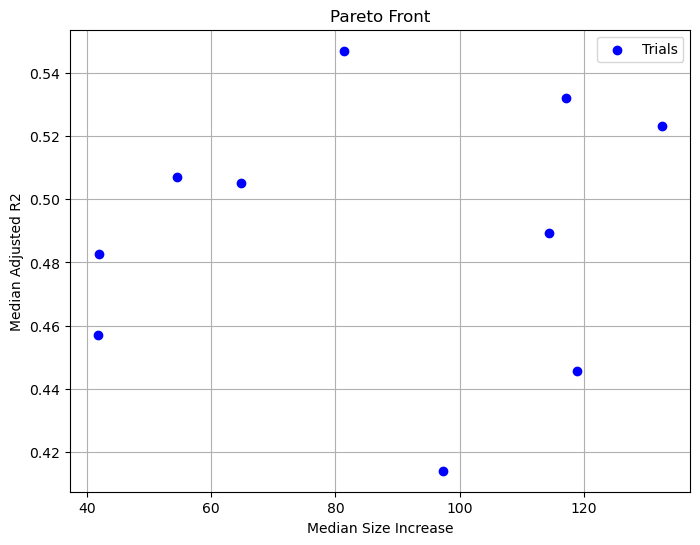

In [4]:
# Results DataFrame
df_pareto = pd.DataFrame(results_list)
print(df_pareto.sort_values(by=['median_r2', 'median_size_increase'], ascending=[False, False]))

# Accessing all metrics_df
all_metrics_dfs = [detail['metrics_df'] for result in results_list for detail in result['details']]

# Plotting the Pareto front
plt.figure(figsize=(8, 6))
plt.scatter(df_pareto['median_size_increase'], df_pareto['median_r2'], c='blue', label='Trials')
plt.xlabel('Median Size Increase')
plt.ylabel('Median Adjusted R2')
plt.title('Pareto Front')
plt.grid(True)
plt.legend()
plt.show()


=== Top Pareto Models ===
   trial  median_r2  median_size_increase  \
1      1   0.546938             81.325767   
5      5   0.531960            117.056406   
9      9   0.522984            132.555488   
4      4   0.506997             54.534691   
2      2   0.505096             64.817073   
8      8   0.489270            114.317220   
0      0   0.482742             41.904674   
7      7   0.457146             41.881373   
3      3   0.445678            118.787056   
6      6   0.414119             97.330963   

                                              params  
1  {'max_heavy': 13, 'max_ratio': 0.4272530046216...  
5  {'max_heavy': 15, 'max_ratio': 0.4801950862471...  
9  {'max_heavy': 17, 'max_ratio': 0.4168681828538...  
4  {'max_heavy': 11, 'max_ratio': 0.2096945341231...  
2  {'max_heavy': 11, 'max_ratio': 0.3085855456528...  
8  {'max_heavy': 14, 'max_ratio': 0.4894097407906...  
0  {'max_heavy': 10, 'max_ratio': 0.3082648231668...  
7  {'max_heavy': 10, 'max_ratio': 0.33

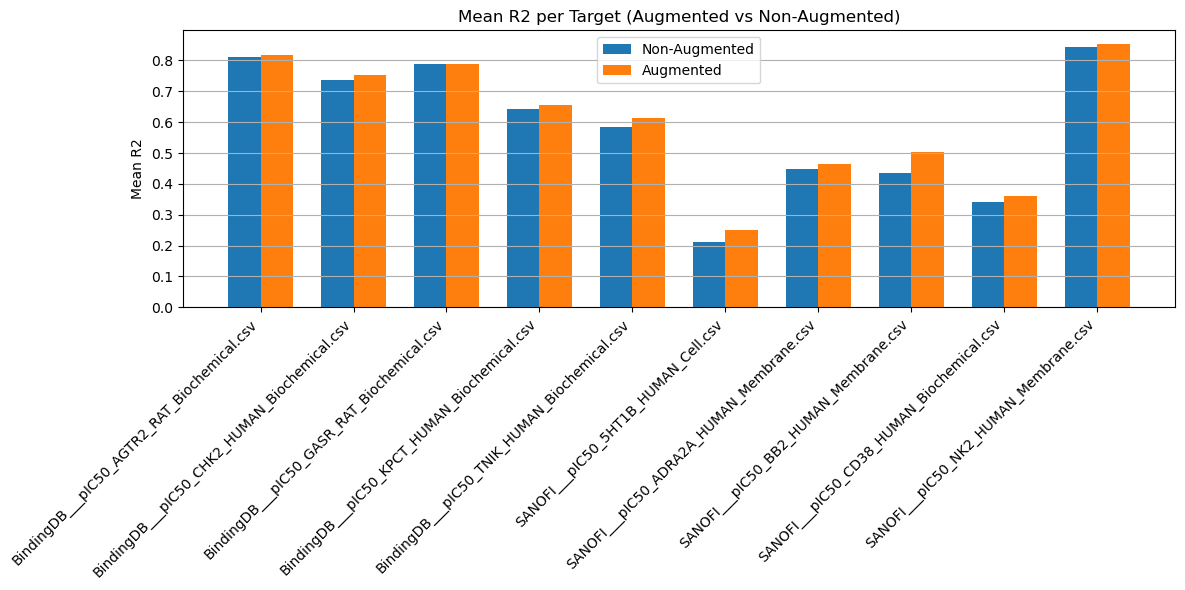

/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_12475/3127464610.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg_df, x='Target', y='Delta_R2', palette='coolwarm')


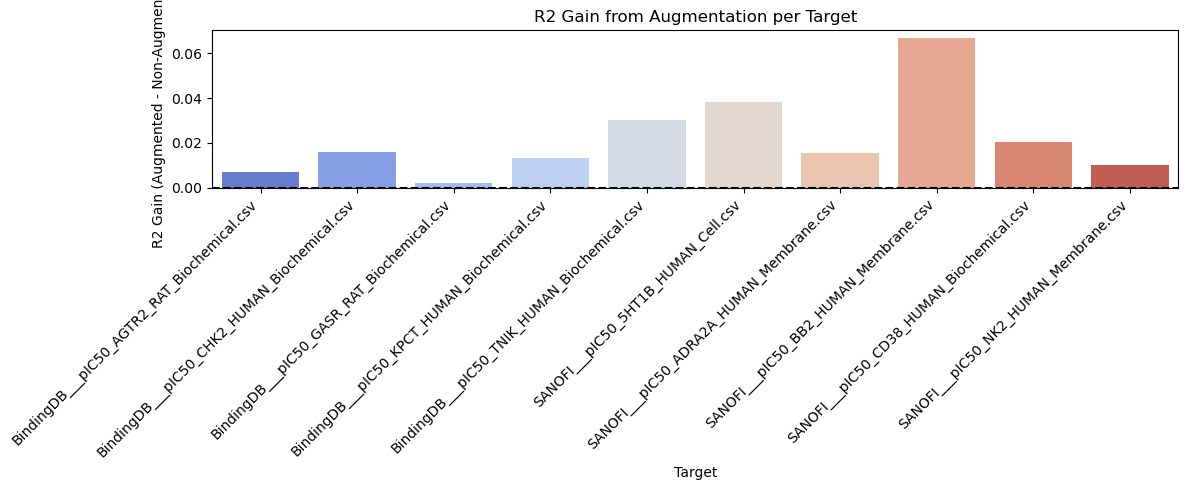

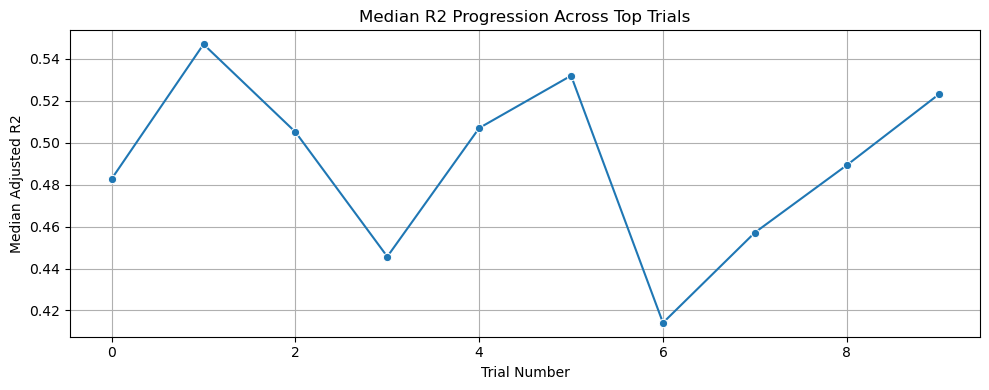

In [ ]:



# Call this after your trials
analyze_top_models_summary(results_list)

=== Top Pareto Models ===
   trial  median_r2  median_size_increase  \
1      1   0.546938             81.325767   
5      5   0.531960            117.056406   
9      9   0.522984            132.555488   
4      4   0.506997             54.534691   
2      2   0.505096             64.817073   
8      8   0.489270            114.317220   
0      0   0.482742             41.904674   
7      7   0.457146             41.881373   
3      3   0.445678            118.787056   
6      6   0.414119             97.330963   

                                              params  
1  {'max_heavy': 13, 'max_ratio': 0.4272530046216...  
5  {'max_heavy': 15, 'max_ratio': 0.4801950862471...  
9  {'max_heavy': 17, 'max_ratio': 0.4168681828538...  
4  {'max_heavy': 11, 'max_ratio': 0.2096945341231...  
2  {'max_heavy': 11, 'max_ratio': 0.3085855456528...  
8  {'max_heavy': 14, 'max_ratio': 0.4894097407906...  
0  {'max_heavy': 10, 'max_ratio': 0.3082648231668...  
7  {'max_heavy': 10, 'max_ratio': 0.33

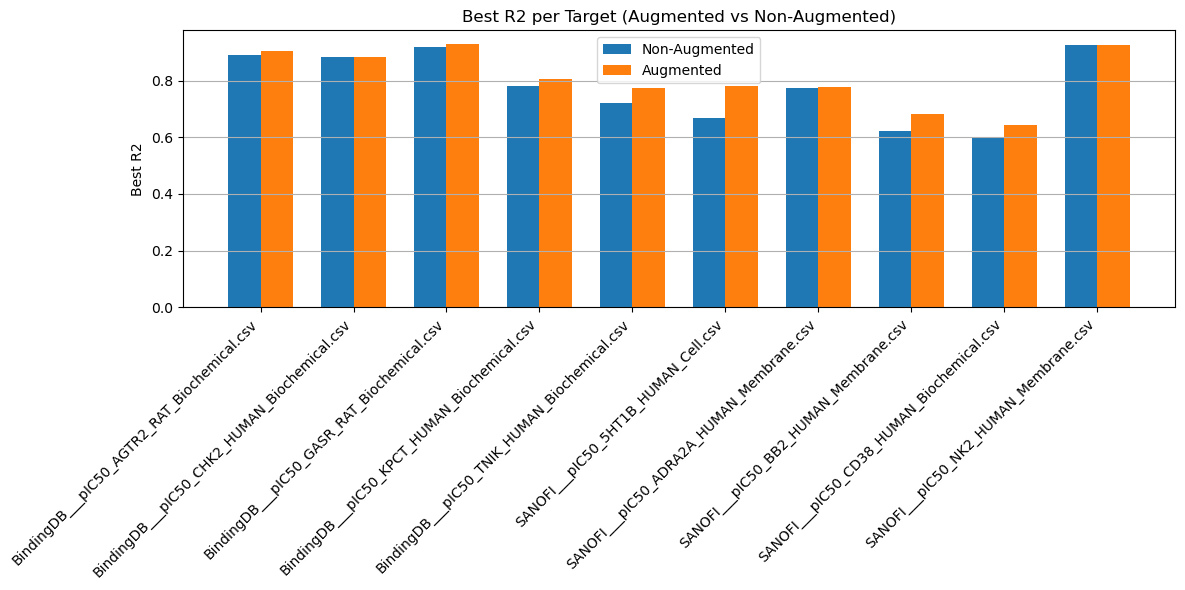

/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_12475/2124425737.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg_df, x='Target', y='Delta_R2', palette='coolwarm')


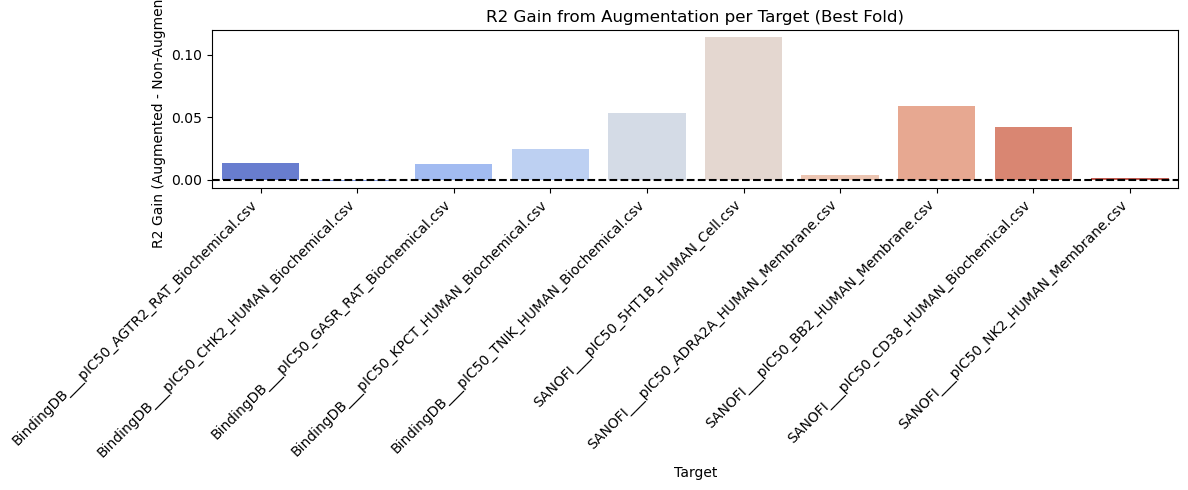

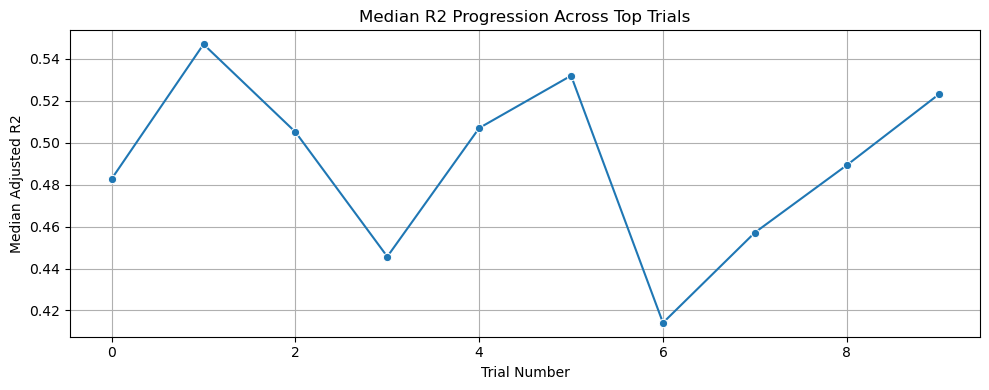

In [ ]:

# Call it after your trials
analyze_top_models_best(results_list)
